
# Epoching a Stream in real-time

.. include:: ./../../links.inc

The :class:`~mne_lsl.stream.EpochsStream` object can be used similarly to
:class:`mne.Epochs` to create epochs from a continuous stream of samples around events
of interest.

<div class="alert alert-info"><h4>Note</h4><p>The :class:`~mne_lsl.stream.EpochsStream` object is designed to work with
    any ``Stream`` object. At the time of writing, only
    :class:`~mne_lsl.stream.StreamLSL` is available, but any object inheriting from the
    abstract :class:`~mne_lsl.stream.BaseStream` object should work.</p></div>

A :class:`~mne_lsl.stream.EpochsStream` object support peak-to-peak rejection, baseline
correction and detrending.

## Event source

A :class:`~mne_lsl.stream.EpochsStream` object requires an event source to create
epochs. 3 event sources are supported:

- a set of ``'stim'`` channels within the attached ``Stream`` object.
- a set of ``'stim'`` channels within a separate ``Stream`` object.
- an irregularly sampled ``Stream`` object.

<div class="alert alert-info"><h4>Note</h4><p>In the case of an irregularly sampled ``Stream`` object, only numerical streams are
    supported at the moment because interaction with ``str`` streams in Python is not
    as performant as interaction with numerical streams.</p></div>

## Set of ``'stim'`` channels

The set of ``'stim'`` channels from which the events are extracted can be either part
of the regularly sampled ``Stream`` object epoched (argument ``stream``) or part of a
separate regularly sampled ``Stream`` object (argument ``event_stream``). In both case,
the channel(s) type should be ``'stim'`` and the channel(s) should be formatted for
:func:`mne.find_events` to correctly extract the events. The channels to consider are
provided in the argument ``event_channels`` and the events to consider in the argument
``event_id``. Let's create epochs around the event ID ``2`` from the ``'STI 014'``
channel of MNE's sample dataset.


In [1]:
import time
import uuid

import numpy as np
from matplotlib import pyplot as plt
from mne import Epochs, EpochsArray, annotations_from_events, find_events
from mne.io import read_raw_fif

from mne_lsl.datasets import sample
from mne_lsl.lsl import resolve_streams
from mne_lsl.player import PlayerLSL
from mne_lsl.stream import EpochsStream, StreamLSL

fname = sample.data_path() / "mne-sample" / "sample_audvis_raw.fif"
raw = read_raw_fif(fname, preload=False).pick(("meg", "stim")).load_data()
source_id = uuid.uuid4().hex
player = PlayerLSL(
    raw,
    chunk_size=200,
    name="tutorial-epochs-1",
    source_id=source_id,
    annotations=False,
).start()
player.info

Opening raw data file C:\Users\masci\mne_data\MNE-LSL-data\sample\mne-sample\sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 27602 ... 153130 =     45.956 ...   254.955 secs
Ready.
Reading 0 ... 125528  =      0.000 ...   208.999 secs...


<Info | 21 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 bads: 1 items (MEG 2443)
 ch_names: MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, MEG 0121, MEG ...
 chs: 204 Gradiometers, 102 Magnetometers, 9 Stimulus
 custom_ref_applied: False
 description: acquisition (megacq) VectorView system at NMR-MGH
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 events: 1 item (list)
 experimenter: MEG
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 172.2 Hz
 meas_date: 2002-12-03 19:01:10 UTC
 meas_id: 4 items (dict)
 nchan: 315
 proj_id: 1 item (ndarray)
 proj_name: test
 projs: PCA-v1: off, PCA-v2: off, PCA-v3: off
 sfreq: 600.6 Hz
>

<div class="alert alert-info"><h4>Note</h4><p>A ``chunk_size`` of 200 samples is used here to ensure stability and reliability
    while building the documentation on the CI. In practice, a ``chunk_size`` of 200
    samples is too large to represent a real-time application.</p></div>

In the cell above, a mock LSL stream is created using the ``'meg'`` and ``'stim'``
channels of MNE's sample dataset. Now, we need to create a
:class:`~mne_lsl.stream.StreamLSL` object connected to this mock LSL stream. The
channel ``"MEG 2443"`` is marked as bad and the signal is filtered with a low-pass
filter.



In [2]:
stream = StreamLSL(bufsize=4, name="tutorial-epochs-1", source_id=source_id)
stream.connect(acquisition_delay=0.1, processing_flags="all")
stream.info["bads"] = ["MEG 2443"]  # remove bad channel
stream.filter(None, 40, picks="grad")  # filter signal
stream.info

<Info | 10 non-empty values
 bads: 1 items (MEG 2443)
 ch_names: MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, MEG 0121, MEG ...
 chs: 204 Gradiometers, 102 Magnetometers, 9 Stimulus
 custom_ref_applied: False
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 highpass: 0.1 Hz
 lowpass: 172.2 Hz
 meas_date: unspecified
 nchan: 315
 projs: PCA-v1: off, PCA-v2: off, PCA-v3: off
 sfreq: 600.6 Hz
>

Now, we can create epochs using this stream as source for both the epochs and the
events. The ``'stim'`` channel ``'STI 014'`` is used to extract the events and epochs
are created around the event ID ``2`` using the gradiometer channels. The epochs are
created around the event, from 200 ms before the event to 500 ms after the event. A
baseline correction is applied using the 200 first ms of the epoch as baseline.



In [3]:
epochs = EpochsStream(
    stream,
    bufsize=20,  # number of epoch held in the buffer
    event_id=2,
    event_channels="STI 014",
    tmin=-0.2,
    tmax=0.5,
    baseline=(None, 0),
    picks="grad",
).connect(acquisition_delay=0.1)
epochs.info

<Info | 8 non-empty values
 bads: []
 ch_names: MEG 0113, MEG 0112, MEG 0122, MEG 0123, MEG 0132, MEG 0133, MEG ...
 chs: 203 Gradiometers
 custom_ref_applied: False
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 highpass: 0.1 Hz
 lowpass: 172.2 Hz
 meas_date: unspecified
 nchan: 203
 projs: []
 sfreq: 600.6 Hz
>

Note the ``bufsize`` argument in the cell above. This argument controls the number of
epochs that are kept in memory. The actual size of the underlying numpy array depends
on the number of epochs, the number of samples (controlled by ``tmin`` and ``tmax``)
and the number of channels.

Let's wait for a couple of epochs to enter in the buffer, and then let's convert the
array to an MNE-Python :class:`~mne.Epochs` object and plot the evoked response.



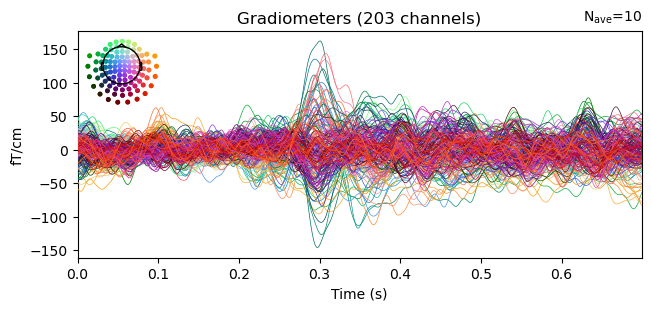

In [4]:
while epochs.n_new_epochs < 10:
    time.sleep(0.5)

data = epochs.get_data(n_epochs=epochs.n_new_epochs)
epochs_mne = EpochsArray(data, epochs.info, verbose="WARNING")
epochs_mne.average().plot()
plt.show()

In [5]:
epochs.disconnect()
stream.disconnect()
player.stop()

<Player: tutorial-epochs-1 | OFF | C:\Users\masci\mne_data\MNE-LSL-data\sample\mne-sample\sample_audvis_raw.fif>

## Irregularly sampled stream

The event source can also be an irregularly sampled stream. In this case, each channel
represents a separate event. A new value entering the buffer of a channel is
interpreted as an event, regardless of the value itself. For instance, we can fake
an irregularly sampled numerical stream using a :class:`~mne_lsl.player.PlayerLSL`
with a :class:`~mne.io.Raw` object which has :class:`~mne.Annotations` attached to it.



In [6]:
events = find_events(raw, stim_channel="STI 014")
events = events[np.isin(events[:, 2], (1, 2))]  # keep only events with ID 1 and 2
annotations = annotations_from_events(
    events,
    raw.info["sfreq"],
    event_desc={1: "ignore", 2: "event"},
    first_samp=raw.first_samp,
)
annotations.duration += 0.1  # set duration since annotations_from_events sets it to 0
annotations

315 events found on stim channel STI 014
Event IDs: [ 1  2  3  4  5 32]


<Annotations | 143 segments: event (72), ignore (71)>

In [8]:
raw.set_annotations(annotations)
player = PlayerLSL(
    raw, chunk_size=200, name="tutorial-epochs-2", source_id=source_id, annotations=True
).start()
player.info

<Info | 21 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 bads: 1 items (MEG 2443)
 ch_names: MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, MEG 0121, MEG ...
 chs: 204 Gradiometers, 102 Magnetometers, 9 Stimulus
 custom_ref_applied: False
 description: acquisition (megacq) VectorView system at NMR-MGH
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 events: 1 item (list)
 experimenter: MEG
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 172.2 Hz
 meas_date: 2002-12-03 19:01:10 UTC
 meas_id: 4 items (dict)
 nchan: 315
 proj_id: 1 item (ndarray)
 proj_name: test
 projs: PCA-v1: off, PCA-v2: off, PCA-v3: off
 sfreq: 600.6 Hz
>

We now have 2 LSL stream availables on the network, one of which is an irregularly
sampled numerical streams of events.



In [9]:
resolve_streams()

[< sInfo 'tutorial-epochs-2-annotations' >
   | Type: annotations
   | Sampling: Irregular
   | Number of channels: 2
   | Data type: <class 'numpy.float64'>
   | Source: a0a6dd14f59044caa8d42a3da14aabe9,
 < sInfo 'tutorial-epochs-2' >
   | Sampling: 600.614990234375 Hz
   | Number of channels: 315
   | Data type: <class 'numpy.float64'>
   | Source: a0a6dd14f59044caa8d42a3da14aabe9]

We can now create a :class:`~mne_lsl.stream.StreamLSL` object for each available
stream on the network.



In [10]:
stream = StreamLSL(bufsize=4, name="tutorial-epochs-2", source_id=source_id)
stream.connect(acquisition_delay=0.1, processing_flags="all")
stream.info["bads"] = ["MEG 2443"]  # remove bad channel
stream.filter(None, 40, picks="grad")  # filter signal
stream.info

<Info | 10 non-empty values
 bads: 1 items (MEG 2443)
 ch_names: MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, MEG 0121, MEG ...
 chs: 204 Gradiometers, 102 Magnetometers, 9 Stimulus
 custom_ref_applied: False
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 highpass: 0.1 Hz
 lowpass: 172.2 Hz
 meas_date: unspecified
 nchan: 315
 projs: PCA-v1: off, PCA-v2: off, PCA-v3: off
 sfreq: 600.6 Hz
>

In [11]:
stream_events = StreamLSL(
    bufsize=20, name="tutorial-epochs-2-annotations", source_id=source_id
)
stream_events.connect(acquisition_delay=0.1, processing_flags="all")
stream_events.info

<Info | 7 non-empty values
 bads: []
 ch_names: event, ignore
 chs: 2 misc
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 0.0 Hz
 meas_date: unspecified
 nchan: 2
 projs: []
 sfreq: 0.0 Hz
>

Let's first inspect the event stream once a couple of samples have been acquired.



In [12]:
while stream_events.n_new_samples < 3:
    time.sleep(0.5)
data, ts = stream_events.get_data(winsize=stream_events.n_new_samples)
print("Array of shape (n_channels, n_samples): ", data.shape)
data

Array of shape (n_channels, n_samples):  (2, 3)


array([[0.1, 0. , 0.1],
       [0. , 0.1, 0. ]])

Each channel corresponds to a given annotation, ``0`` to ``'ignore'`` and ``1`` to
``'event'``. The value is ``0`` when no annotation is present, and ``x`` when an
annotation is present, with ``x`` being the duration of the annotation.

Thus, this array can be interpreted as follows:

```python
array([[0.1, 0. , 0.1],
      [0. , 0.1, 0. ]])
```
- An annotation of 0.1 seconds labelled ``'ignore'`` was received at ``ts[0]``.
- An annotation of 0.1 seconds labelled ``'event'`` was received at ``ts[1]``.
- An annotation of 0.1 seconds labelled ``'ignore'`` was received at ``ts[2]``.

We can now use those 2 streams to create epochs around the events of interest.



In [13]:
epochs = EpochsStream(
    stream,
    bufsize=20,  # number of epoch held in the buffer
    event_id=None,
    event_channels="event",  # this argument now selects the events of interest
    event_stream=stream_events,
    tmin=-0.2,
    tmax=0.5,
    baseline=(None, 0),
    picks="grad",
).connect(acquisition_delay=0.1)
epochs.info

<Info | 8 non-empty values
 bads: []
 ch_names: MEG 0113, MEG 0112, MEG 0122, MEG 0123, MEG 0132, MEG 0133, MEG ...
 chs: 203 Gradiometers
 custom_ref_applied: False
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 highpass: 0.1 Hz
 lowpass: 172.2 Hz
 meas_date: unspecified
 nchan: 203
 projs: []
 sfreq: 600.6 Hz
>

Let's wait for a couple of epochs to enter in the buffer, and then let's convert the
array to an MNE-Python :class:`~mne.Epochs` object and plot the time-frequency
representation of the evoked response.



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s


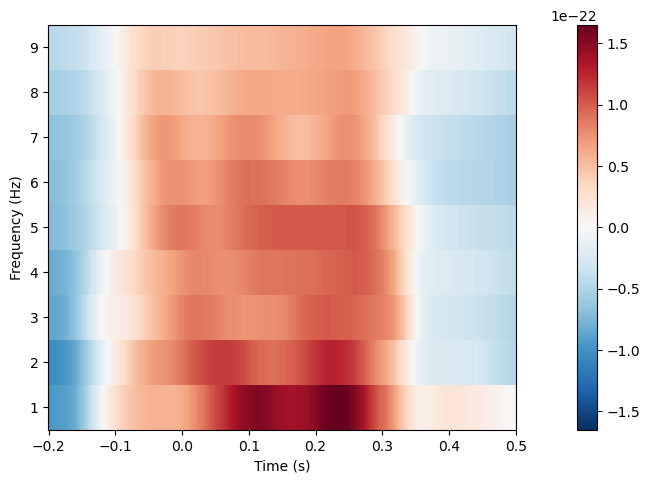

In [14]:
while epochs.n_new_epochs < 10:
    time.sleep(0.5)

data = epochs.get_data(n_epochs=epochs.n_new_epochs)
epochs_mne = EpochsArray(data, epochs.info, tmin=-0.2, verbose="WARNING")
freqs = np.arange(1, 10)
tfr = epochs_mne.average().compute_tfr(
    method="multitaper", freqs=freqs, n_cycles=freqs / 2
)
tfr.plot(baseline=(None, 0), combine="mean")
plt.show()

Let's compare this to a :class:`~mne.Epochs` object created from the same number of
events offline.

<div class="alert alert-info"><h4>Note</h4><p>The same epochs were not selected between the offline and online processing.</p></div>



Not setting metadata
72 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 72 events and 421 original time points ...
0 bad epochs dropped
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 199 samples (0.331 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    0.6s
[Parallel(n_job

Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


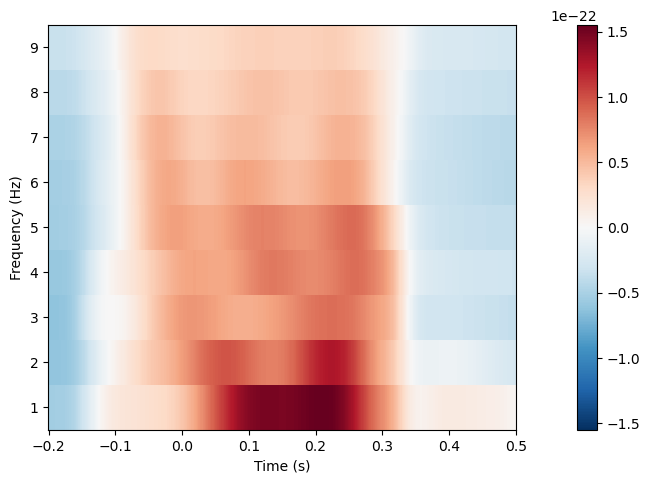

In [15]:
epochs_offline = Epochs(
    raw, events, event_id=dict(event=2), baseline=(None, 0), picks="grad", preload=True
)
epochs_offline.filter(None, 40)
tfr = epochs_offline.average().compute_tfr(
    method="multitaper", freqs=freqs, n_cycles=freqs / 2
)
tfr.plot(baseline=(None, 0), combine="mean")
plt.show()

Finally, in this case a single event was kept in the
:class:`~mne_lsl.stream.EpochsStream`, but if more events are retained, it is
important to know which one is which. This information is stored in the property
:attr:`~mne_lsl.stream.EpochsStream.events` of the
:class:`~mne_lsl.stream.EpochsStream`, which is an internal buffer of the event codes.



In [16]:
epochs.events

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int16)

<div class="alert alert-info"><h4>Note</h4><p>In the case of an irregularly sampled event stream, the event code represents the
    channel idx within the event stream.</p></div>

## Free resources

When you are done with a :class:`~mne_lsl.player.PlayerLSL`, a
:class:`~mne_lsl.stream.StreamLSL` or a :class:`~mne_lsl.stream.EpochsStream` don't
forget to free the resources they use to continuously mock an LSL stream or
receive new data from an LSL stream.



In [17]:
epochs.disconnect()

<EpochsStream OFF (n: 20 between (-0.2, 0.5 seconds)> connected to:
	<Stream: ON | tutorial-epochs-2 (source: a0a6dd14f59044caa8d42a3da14aabe9)>

In [18]:
stream.disconnect()

<Stream: OFF | tutorial-epochs-2 (source: a0a6dd14f59044caa8d42a3da14aabe9)>

In [19]:
player.stop()

<Player: tutorial-epochs-2 | OFF | C:\Users\masci\mne_data\MNE-LSL-data\sample\mne-sample\sample_audvis_raw.fif>